# Getting started with Bifrost

Once Bifrost is installed you can load the Python API with:

In [1]:
%%bash
# @title Build and install
export LD_LIBRARY_PATH=/usr/local/lib:${LD_LIBRARY_PATH}
if python -c 'import bifrost' 2>/dev/null; then
    echo "Great, bifrost import seems to work."
    exit 0
else
    if python -c 'import google.colab' 2>/dev/null; then
        echo "No bifrost but we're on Google Colab, so will try to install."
    else
        echo "Sorry, please use a runtime with access to Bifrost."
        exit 1
    fi
fi
sudo apt-get -qq install exuberant-ctags libopenblas-dev software-properties-common build-essential
pip install -q contextlib2 pint simplejson scipy git+https://github.com/ctypesgen/ctypesgen.git
if [ ! -d ~/bifrost/.git ]; then
  git clone https://github.com/ledatelescope/bifrost ~/bifrost
fi
cd ~/bifrost
./configure && make -j all && sudo make install

No bifrost but we're on Google Colab, so will try to install.
Selecting previously unselected package exuberant-ctags.
(Reading database ... 155202 files and directories currently installed.)
Preparing to unpack .../exuberant-ctags_1%3a5.9~svn20110310-11_amd64.deb ...
Unpacking exuberant-ctags (1:5.9~svn20110310-11) ...
Setting up exuberant-ctags (1:5.9~svn20110310-11) ...
update-alternatives: using /usr/bin/ctags-exuberant to provide /usr/bin/ctags (ctags) in auto mode
update-alternatives: using /usr/bin/ctags-exuberant to provide /usr/bin/etags (etags) in auto mode
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking fo

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Cloning into '/root/bifrost'...
./configure: line 7420: /usr/bin/file: No such file or directory
configure: WARNING: doxygen not found - will not generate any doxygen documentation
configure: WARNING: This version of cuFFT may have unexpected behavior for complex-to-real transforms
transpose.cu: In function ‘BFstatus transpose_simple(const BFarray*, const 
   BFarray*, const int*)’:
transpose.cu:319:32: warning: ‘axes_inverted’ may be used uninitialized in 
   this function [-Wmaybe-uninitialized]
  func_str += hex_digits[axes[0]];
             

In [2]:
import bifrost

This loads the core parts of Bifrost and several useful functions.  The main way of interacting with Bifrost is through the `bifrost.ndarray`, a sub-class of `numpy.ndarray`.  You can create an empty array with:

In [3]:
data = bifrost.ndarray(shape=(2,4096), dtype='f32', space='system')
print(type(data), data.dtype, data.shape, data.bf.space)
print(data)

<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) system
[[9.7624806e-36 0.0000000e+00 1.5581004e-38 ... 1.3563156e-19
  2.8297670e+20 2.6373977e+23]
 [2.0704474e-19 7.1220526e+28 1.4251251e-13 ... 7.6813502e+31
  1.8970232e+31 7.2250739e+28]]


Note that bifrost defines datatypes differently to numpy:
```
f32: 32-bit float (equivalent to numpy float32)
cf32: complex 32-bit data (equivalent to numpy complex64)
i[8,16,32]: signed integer datatypes of 8, 16 and 32-bit width
u[8,16,32]: unsigned integer datatypes of 8, 16 and 32-bit width
ci[4,8,16,32]: complex 4-bit per sample, 8-bit, 16-bit and 32-bit datatypes
```

The `ci4`, `ci8` and `ci16` datatypes do not have an equivalent numpy type, but are commonly encountered in radio astronomy.

You can also use the `bifrost.ndarray` to wrap existing numpy arrays:

In [4]:
import numpy
r = numpy.random.randn(2, 4096)
data = bifrost.ndarray(r)
print(type(data), data.dtype, data.shape, data.bf.space)
print('r:', r)
print('data:', data)

<class 'bifrost.ndarray.ndarray'> float64 (2, 4096) system
r: [[ 0.14467437 -0.9858471  -0.29228502 ...  1.52117552  0.11308428
   1.18072678]
 [-1.0376523  -0.79953079  0.29897504 ... -0.09453896 -0.07558208
  -0.11985499]]
data: [[ 0.14467437 -0.9858471  -0.29228502 ...  1.52117552  0.11308428
   1.18072678]
 [-1.0376523  -0.79953079  0.29897504 ... -0.09453896 -0.07558208
  -0.11985499]]


Since `bifrost.ndarray`s are derived from numpy arrays they can do many (but not all) of the same things:

In [5]:
data += 2.0
print('data += 2.0:', data)
data[0,:] = 55
print('data[0,:] = 55:', data)

data += 2.0: [[2.14467437 1.0141529  1.70771498 ... 3.52117552 2.11308428 3.18072678]
 [0.9623477  1.20046921 2.29897504 ... 1.90546104 1.92441792 1.88014501]]
data[0,:] = 55: [[55.         55.         55.         ... 55.         55.
  55.        ]
 [ 0.9623477   1.20046921  2.29897504 ...  1.90546104  1.92441792
   1.88014501]]


In [6]:
data[:,[1,3,5,7]] = 10
print('data[:,[1,3,5,7]] = 10:', data)

data[:,[1,3,5,7]] = 10: [[55.         55.         55.         ... 55.         55.
  55.        ]
 [ 0.9623477   1.20046921  2.29897504 ...  1.90546104  1.92441792
   1.88014501]]


You can also use `bifrost.ndarray`s with [numba](https://numba.pydata.org/):

In [7]:
from numba import jit

@jit(nopython=True)
def compute(x):
    for i in range(len(x)):
        x[i] = x[i] + 10

compute(data)
print(type(data), data)



<class 'bifrost.ndarray.ndarray'> [[65.         65.         65.         ... 65.         65.
  65.        ]
 [10.9623477  11.20046921 12.29897504 ... 11.90546104 11.92441792
  11.88014501]]


### Arrays on the CPU and GPU

Unlike numpy arrays `bifrost.ndarray` are "space aware", meaning that they can exist in different memory spaces.  What we have created so far is in system memory.  `bifrost.ndarray`s can also exist in "cuda_host" (pinned) memory and "cuda" (GPU) memory:

In [8]:
data2 = bifrost.ndarray(shape=(2,4096), dtype='f32', space='cuda_host')
data3 = bifrost.ndarray(shape=(2,4096), dtype='f32', space='cuda')
print(type(data2), data2.dtype, data2.shape, data2.bf.space)
print(type(data3), data3.dtype, data3.shape, data3.bf.space)

<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) cuda_host
<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) cuda


To move between the different spaces the `bifrost.ndarray` class provides a `copy` method:

In [9]:
data4 = data.copy(space='cuda')
print(type(data4), data4.dtype, data4.shape, data4.bf.space)

<class 'bifrost.ndarray.ndarray'> float64 (2, 4096) cuda


Once on the GPU you can take advantage of Bifrost's GPU-based functions, like `bifrost.map`:

In [10]:
bifrost.map("a(i,j) *= 10",
            {'a': data4},
            axis_names=('i', 'j'),
            shape=data4.shape)
data4 = data4.copy(space='system')
print('data4/data = data*10/data = 10:', data4/data)

data4/data = data*10/data = 10: [[10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]]


The `bifrost.map` call here compiles and runs a CUDA kernel that does an element-wise multiplication by ten.  In order to view the results of this kernel call we need to copy the memory back to the "system" memory space.  In the future we hope to support a "cuda_managed" space to make this easier.

`bifrost.map` is an example of a function that does not require any additional setup to run. This code is converted into a CUDA kernel at runtime, using [NVRTC](https://docs.nvidia.com/cuda/nvrtc/index.html). 

For some Bifrost functions, like `bifrost.fft.Fft`, some setup is required so that the function knows how to run. To show the use of the Bifrost FFT, let us first make some example data on the GPU, using `bf.map`:

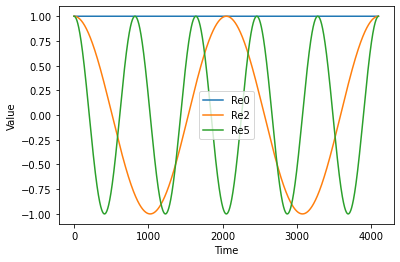

In [11]:
data = bifrost.ndarray(shape=(16, 4096), dtype='cf32', space='cuda')
bifrost.map("a(i,j) = exp(Complex<float>(0.0, 2*3.14*i*j/4096))",
            {'a': data},
            axis_names=('i', 'j'),
            shape=data.shape)
data2 = data.copy(space='system')

import pylab
pylab.plot(data2[0,:].real, label='Re0')
#pylab.plot(data2[0,:].imag, label='Im0')
pylab.plot(data2[2,:].real, label='Re2')
#pylab.plot(data2[2,:].imag, label='Im2')
pylab.plot(data2[5,:].real, label='Re5')
#pylab.plot(data2[5,:].imag, label='Im5')
pylab.xlabel('Time')
pylab.ylabel('Value')
pylab.legend(loc=0)

Now run the FFT and plot the results. The FFT is initialised using its `.init` method, and then executed using its `.execute` method.  An output data array also needs to be pre-allocated :

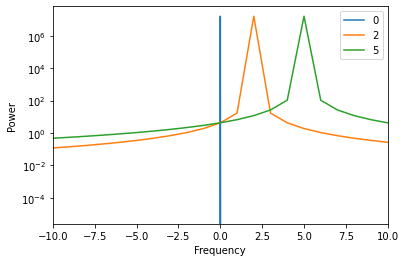

In [12]:
fdata = bifrost.ndarray(shape=data.shape, dtype='cf32', space='cuda')
f = bifrost.fft.Fft()
f.init(data, fdata, axes=1, apply_fftshift=True)
f.execute(data, fdata)
fdata2 = fdata.copy(space='system')
ffreqs = numpy.fft.fftfreq(fdata2.shape[1], d=1/4096.)
ffreqs = numpy.fft.fftshift(ffreqs)

pylab.semilogy(ffreqs, numpy.abs(fdata2[0,:])**2, label='0')
pylab.semilogy(ffreqs, numpy.abs(fdata2[2,:])**2, label='2')
pylab.semilogy(ffreqs, numpy.abs(fdata2[5,:])**2, label='5')
pylab.xlabel('Frequency')
pylab.ylabel('Power')
pylab.xlim(-10, 10)
pylab.legend(loc=0)